In [10]:
%load_ext autoreload
%autoreload 2

from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_squared_log_error, recall_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn import svm, tree 
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import sys
sys.path.insert(0, '/Users/pauor506/Documents/PP_active_learning/')
import utils as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Reading dataset (from https://www.kaggle.com/datasets/mathchi/diabetes-data-set?resource=download)
diabetes = pd.read_csv('/Users/pauor506/Documents/PP_active_learning/Easy_diabetes_dataset/diabetes.csv')

#### Let's replaces the "non-sense" values with the mean

In [3]:
diabetes['Glucose']=diabetes['Glucose'].replace(0,diabetes['Glucose'].mean())
diabetes['BloodPressure']=diabetes['BloodPressure'].replace(0,diabetes['BloodPressure'].mean())
diabetes['SkinThickness']=diabetes['SkinThickness'].replace(0,diabetes['SkinThickness'].mean())
diabetes['Insulin']=diabetes['Insulin'].replace(0,diabetes['Insulin'].mean())
diabetes['BMI']=diabetes['BMI'].replace(0,diabetes['BMI'].mean())

diabetes.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


In [4]:
# Creating X and y sets
X_init = diabetes.drop(['Outcome'], axis=1).to_numpy() # I am using all the features for prediction
y = diabetes['Outcome'].to_numpy()

In [5]:
# Scaling features with min-max scaling
X_mm = MinMaxScaler(feature_range=(0,1)).fit_transform(X_init)

# Scaled feature with standardization
X_std = StandardScaler().fit_transform(X_init)

### 1.1: Using the default data set and train/trst split

In [6]:
# Parameters for ML model
test_size = 0.2
n_neighbours = 3

# Data for training and testing
X_train_mm, X_test_mm, y_train, y_test = train_test_split(X_mm, y, test_size=test_size, random_state=9827)
X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size=test_size, random_state=9827)


# Models
knn = KNeighborsClassifier(n_neighbors = n_neighbours)
lrg = LogisticRegression(random_state=0, max_iter=200)
rf = RandomForestClassifier(max_depth=3, random_state=0)
svmm = svm.SVC(random_state=0)
ada_clf = AdaBoostClassifier(random_state=0) #DecisionTreeClassifier initialized with max_depth=1 and 50 trees

In [7]:
# Training basic models
models = [knn, lrg, rf, svmm, ada_clf]
accuracies_mm, f1_scores_mm = utils.basic_training_by_model_list( X_train_mm, X_test_mm, y_train, y_test, models)
accuracies_std, f1_scores_std = utils.basic_training_by_model_list( X_train_std, X_test_std, y_train, y_test, models)

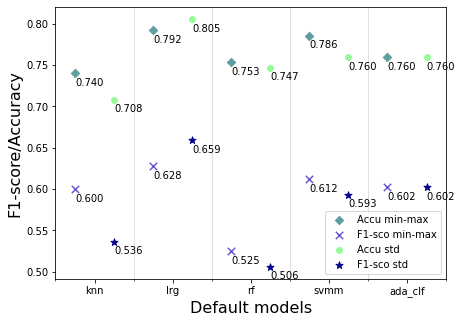

In [11]:
models_names =['knn', 'lrg', 'rf','svmm', 'ada_clf']
utils.plot_score_comparision(accuracies_mm, f1_scores_mm, accuracies_std, f1_scores_std, models_names)

### 1.2: K-fold cross validation

In [ ]:
# This function plots two lists: accuracy and f1-scores. They must be represented as ONE poin per model
def plotting(_models_names, _accuracies, _f1_scores, title):
    fig, ax1, = plt.subplots(1,1,figsize=(7,6))
    xx = np.arange(len(_accuracies))
    ax1.scatter(xx, _accuracies, marker = 'D', s=35, color='cadetblue')
    ax1.scatter(xx, _f1_scores, marker = 'o', s=55, color='slateblue')

    ax1.set_ylabel('F1-score/Accuracy', color = 'black', fontsize = 16)
    ax1.set_ylabel('Default models', color = 'black', fontsize = 16)
    ax1.legend(['Accuracy', 'F1-score'])
    ax1.set_title(title)

    # Annotating points
    for i, txt in enumerate(["{0:0.2f}".format(i) for i in _accuracies]):
        ax1.annotate(txt, (xx[i], _accuracies[i]-0.015))

    # Annotating points
    for i, txt in enumerate(["{0:0.2f}".format(i) for i in _f1_scores]):
        ax1.annotate(txt, (xx[i], _f1_scores[i]+0.015))

    plt.xticks(ticks=np.arange(0,5), labels=models_names)

    plt.show()

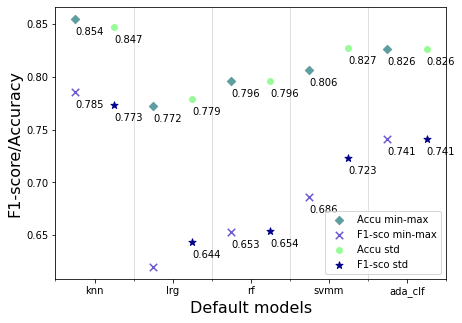

In [13]:
# Training with KFold cross validation
cv_number = 5

kfold_validation=KFold(cv_number)
acc_cv_x_model_mm, f1_cv_x_model_mm = utils.train_x_modelList(models, X_mm, y, kfold_validation)
acc_cv_x_model_std, f1_cv_x_model_std = utils.train_x_modelList(models, X_std, y, kfold_validation)

utils.plot_score_comparision(acc_cv_x_model_mm, f1_cv_x_model_mm, acc_cv_x_model_std, f1_cv_x_model_std, models_names)


### 1.3: Stratified KFold cross validation

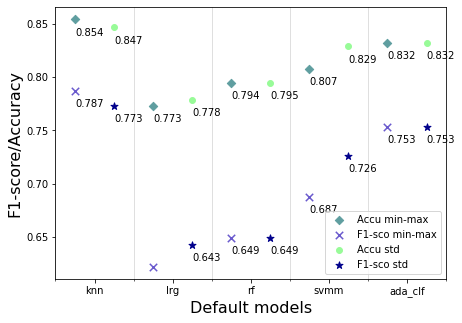

In [14]:
from sklearn.model_selection import StratifiedKFold

sk_fold=StratifiedKFold(n_splits = cv_number)

acc_cv_str_x_model_mm, f1_cv_str_x_model_mm = utils.train_x_modelList(models, X_mm, y, sk_fold)
acc_cv_str_x_model_std, f1_cv_str_x_model_std = utils.train_x_modelList(models, X_std, y, sk_fold)

utils.plot_score_comparision(acc_cv_str_x_model_mm, f1_cv_str_x_model_mm, acc_cv_str_x_model_std, f1_cv_str_x_model_std, models_names)